# Magnification factor of $\beta$-VAE toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
April 30, 2024 <br/>

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p_{\varphi}(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p_{\varphi}(x)=\int \mathrm{d}z \;p_{\varphi}(x, z)$.
$$
\begin{gathered}
q_\phi(x, z) = q(x) q_\phi(z \mid x) \\
p_{\varphi}(x, z) = p(z) p_{\varphi}(x \mid z)
\end{gathered}
$$
The variational principle bypasses this problem by optimizing a lower bound on the log-likelihood of the data. In this case, the objective $\mathcal{L}_{\mathrm{VAE-ELBO}}$:
$$
\begin{aligned}
\mathbb{E}_{q(x)}\left[\log p_{\varphi}(x)\right] & =\mathbb{E}_{q(x)}\left[\log \int p_{\varphi}(x, \psi) d \psi\right] \\
& =\mathbb{E}_{q(x)}\left[\log \int q_\phi(\psi \mid x) \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& \geq \mathbb{E}_{q(x)}\left[\int q_\phi(\psi \mid x) \log \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& =\mathbb{E}_{q_\phi(x, \psi)}\left[\log p_{\varphi}(x \mid \psi)\right]-\mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(\psi \mid x) \| p(\psi)\right)\right] := \mathcal{L}_{\mathrm{VAE-ELBO}}
\end{aligned}
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ is given as a slight modification of the ELBO of VAE:
$$
\mathcal{L}_{\beta-\mathrm{VAE}} := \mathbb{E}_{q_\phi(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ can be derived according to the variational principle by modifying the respective encoder and decoder models as follows:
$$
\begin{aligned}
& q_{\beta, \phi}(x, z)=\frac{q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta)} . \\
& p_{\beta, \varphi}(x, z)=\frac{p(z) p_{\varphi}^\beta(x \mid z)}{Z_p(\beta)} .
\end{aligned}
$$
$$
\begin{aligned}
\mathcal{L}_{\mathrm{Neq-VAE}} &:= \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q^\beta(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
\end{aligned}
$$
$$
\begin{aligned}
-\frac{1}{\beta} D_{\mathrm{KL}}\left(q_{\beta, \phi}(x, z) \| p_{\beta, \varphi}(x, z)\right) & =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{q_{\beta, \phi}(x, z)}{p_{\beta, \varphi}(x, z)}\right] \\
& =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{Z_p(\beta) q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta) p(z) p_{\varphi}^\beta(x \mid z)}\right] \\
& =\frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\text{Neq-VAE}} \\
& \geq \frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\beta-\mathrm{VAE}} .
\end{aligned}
$$

This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Create dataset of one-hot vectors

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
import sklearn.preprocessing as sp
import sklearn.model_selection as sm
import matplotlib
import mplcyberpunk
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

plt.style.use("cyberpunk")

# Load training datasets
MNIST = datasets.load_digits()
X = MNIST.data  # X: images
X = X / 16  # Normalize pixel values
yl = MNIST.target  # yl: labels
D, n = X.shape

n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D), n_im, replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

# Split the dataset into train and test datasets
X_train, X_test, yl_train, yl_test = sm.train_test_split(X, yl, train_size=1/2, test_size=1/2)

X_test = X_test[:-1]
yl_test = yl_test[:-1]

# create dataset of one-hot vectors
# class size
C = 10                      
# .A means 'change the data type from a matrix to an array'
enc = sp.OneHotEncoder()
Y_train = enc.fit_transform(yl_train.reshape(-1, 1)).A
Y_test = enc.fit_transform(yl_test.reshape(-1, 1)).A

print('訓練データ数：D_train =', len(Y_train))
print('テストデータ数：D_test =', len(Y_test))

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

訓練データ数：D_train = 898
テストデータ数：D_test = 898


## Setup

In [2]:
# Constants
n_epoch = 100000 + 1
batch_size = X_train.shape[0]
latent_dim = 2  # Assuming latent_dim is 2 for this example
n_layer = 4  # Assuming n_layer is 4 for this example
n_unit = 258  # Assuming n_unit is 256 for this example
output_dim = Y_train.shape[1]  # Assuming output_dim is the number of classes

# Data
x = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(Y_train, dtype=torch.float32)

# データセットの準備
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim) for i in range(n_layer)])
        self.loc = nn.Linear(hidden_dim, latent_dim)
        self.scale = nn.Linear(hidden_dim, latent_dim)
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        enc = self.fc_layers(x)
        loc = self.loc(enc)
        scale = 1e-6 + (1 - 2e-6) * self.softplus(self.scale(enc))
        return loc, scale

# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else latent_dim, hidden_dim) for i in range(n_layer)])
        self.dec = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        dec = self.fc_layers(z)
        dec = 1e-6 + (1 - 2e-6) * self.sigmoid(self.dec(dec))
        return dec

# Instantiate networks
encoder = Encoder(input_dim=x.shape[1], hidden_dim=n_unit, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=n_unit, output_dim=output_dim)
encoder_params = dict(encoder.named_parameters())
decoder_params = dict(decoder.named_parameters())

/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_31250/2736874439.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_31250/2736874439.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_31250/2736874439.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tens

In [3]:
def compute_jacobian(model, params, input):
    func = torch.func.functional_call(model, params, input)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=torch.ones_like(func[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=func[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_logprobs(model, params, input, cyclical_beta, j):
    func = torch.func.functional_call(model, params, input)
    log_probs = Bernoulli(probs=func.pow_(cyclical_beta[j])).log_prob(y)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=torch.ones_like(log_probs[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=log_probs[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_magnification_factor(J):
    """
    creates the metric tensor (J^T J and J being the jacobian of the decoder), 
    which can be evaluated at any point in Z
    and
    the magnification factor
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # magnification factor
    mf = torch.sqrt(torch.det(G))
    return mf

def compute_fisher_information_factor(J):
    """
    Computes the Fisher Information Factor using the Jacobian matrix.
    
    Args:
    - jacobian (torch.Tensor): The Jacobian matrix. Shape: [batch_size, output_dim, input_dim].
    
    Returns:
    - fif (torch.Tensor): The Fisher Information Factor. Shape: [batch_size].
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # fisher information factor
    fif = torch.diagonal(G, dim1=1, dim2=2).sum(dim=1)
    return fif

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.view(x_size, 1, dim).expand(x_size, y_size, dim)
    tiled_y = y.view(1, y_size, dim).expand(x_size, y_size, dim)
    return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / dim)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

  0%|          | 0/100001 [00:00<?, ?it/s]

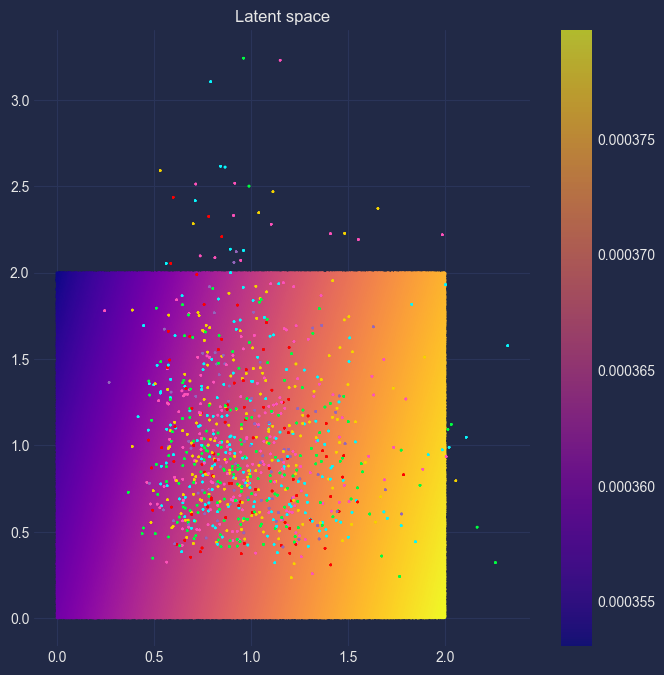

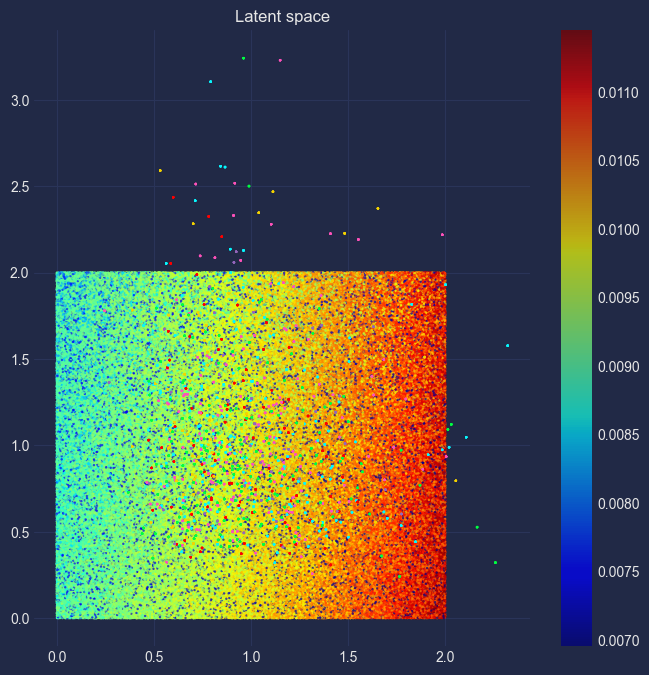

  0%|          | 11/100001 [00:20<37:08:27,  1.34s/it]

    0:(beta)=(    0.8000)


  1%|          | 1022/100001 [00:28<13:26, 122.74it/s]

 1000:(beta)=(    0.6082)


  2%|▏         | 2023/100001 [00:36<13:26, 121.51it/s]

 2000:(beta)=(    0.6912)


  3%|▎         | 3011/100001 [00:45<13:21, 121.00it/s]

 3000:(beta)=(    0.9301)


  4%|▍         | 4017/100001 [00:53<13:56, 114.79it/s]

 4000:(beta)=(    0.9826)


  5%|▌         | 5019/100001 [01:02<13:34, 116.59it/s]

 5000:(beta)=(    0.7735)


  6%|▌         | 6019/100001 [01:11<13:15, 118.21it/s]

 6000:(beta)=(    0.6024)


  7%|▋         | 7015/100001 [01:20<13:05, 118.31it/s]

 7000:(beta)=(    0.7144)


  8%|▊         | 8024/100001 [01:28<12:48, 119.69it/s]

 8000:(beta)=(    0.9491)


  9%|▉         | 9019/100001 [01:37<12:57, 117.08it/s]

 9000:(beta)=(    0.9701)


 10%|▉         | 9996/100001 [02:00<12:38, 118.64it/s]

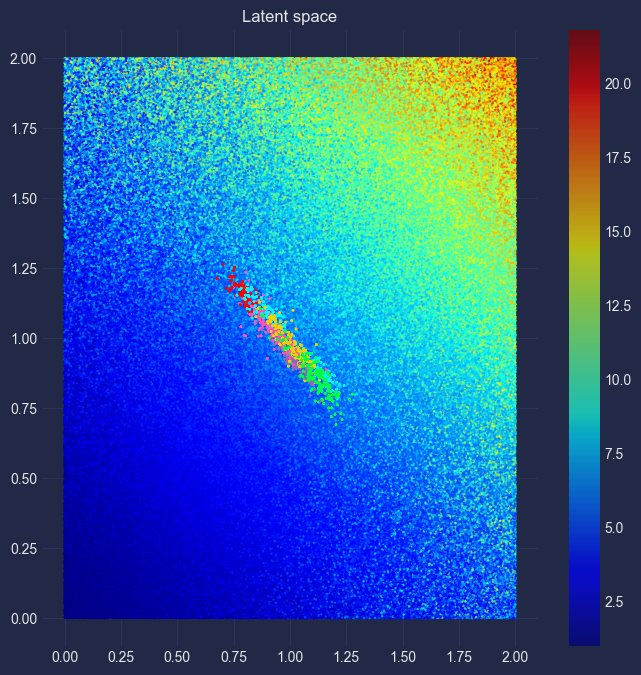

 10%|█         | 10012/100001 [02:06<11:14:31,  2.22it/s]

10000:(beta)=(    0.7474)


 11%|█         | 11015/100001 [02:16<13:20, 111.21it/s]  

11000:(beta)=(    0.6000)


 12%|█▏        | 12018/100001 [02:25<13:26, 109.06it/s]

12000:(beta)=(    0.7392)


 13%|█▎        | 13011/100001 [02:35<14:29, 100.03it/s]

13000:(beta)=(    0.9654)


 14%|█▍        | 14020/100001 [02:44<13:12, 108.45it/s]

14000:(beta)=(    0.9547)


 15%|█▌        | 15015/100001 [02:54<12:49, 110.39it/s]

15000:(beta)=(    0.7223)


 16%|█▌        | 16013/100001 [03:03<12:48, 109.24it/s]

16000:(beta)=(    0.6012)


 17%|█▋        | 17012/100001 [03:12<12:21, 111.88it/s]

17000:(beta)=(    0.7650)


 18%|█▊        | 18020/100001 [03:21<12:40, 107.73it/s]

18000:(beta)=(    0.9789)


 19%|█▉        | 19021/100001 [03:30<12:05, 111.65it/s]

19000:(beta)=(    0.9365)


 20%|█▉        | 19996/100001 [03:50<11:58, 111.31it/s]

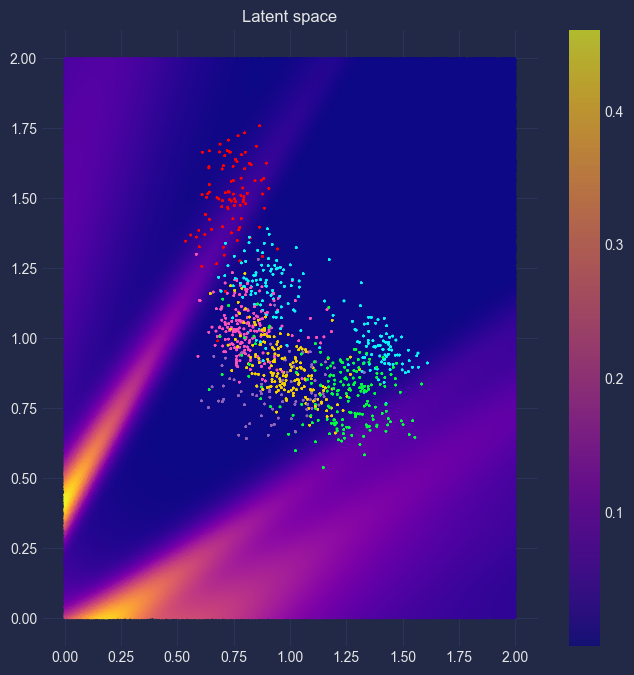

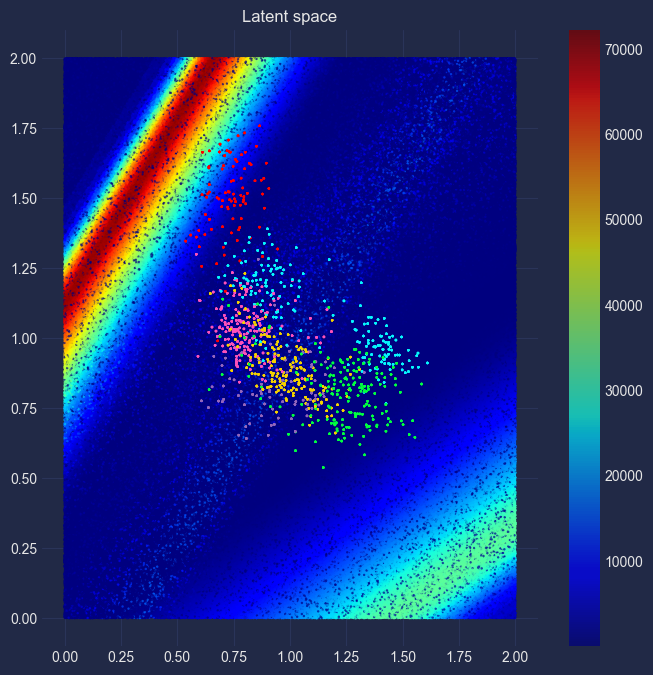

 20%|██        | 20011/100001 [04:01<10:20:16,  2.15it/s]

20000:(beta)=(    0.6986)


 21%|██        | 21024/100001 [04:10<11:28, 114.78it/s]  

21000:(beta)=(    0.6059)


 22%|██▏       | 22014/100001 [04:19<11:28, 113.19it/s]

22000:(beta)=(    0.7914)


 23%|██▎       | 23011/100001 [04:28<11:37, 110.43it/s]

23000:(beta)=(    0.9892)


 24%|██▍       | 24018/100001 [04:36<09:57, 127.23it/s]

24000:(beta)=(    0.9159)


 25%|██▌       | 25016/100001 [04:45<10:13, 122.17it/s]

25000:(beta)=(    0.6766)


 26%|██▌       | 26026/100001 [04:52<09:23, 131.21it/s]

26000:(beta)=(    0.6141)


 27%|██▋       | 27016/100001 [05:00<09:55, 122.62it/s]

27000:(beta)=(    0.8179)


 28%|██▊       | 28013/100001 [05:09<10:38, 112.76it/s]

28000:(beta)=(    0.9961)


 29%|██▉       | 29013/100001 [05:18<10:48, 109.47it/s]

29000:(beta)=(    0.8933)


 30%|██▉       | 29992/100001 [05:40<10:08, 115.07it/s]

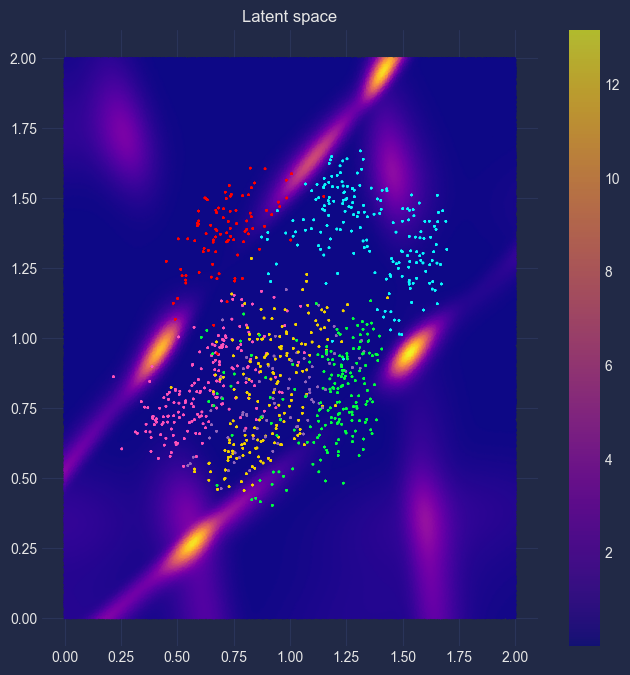

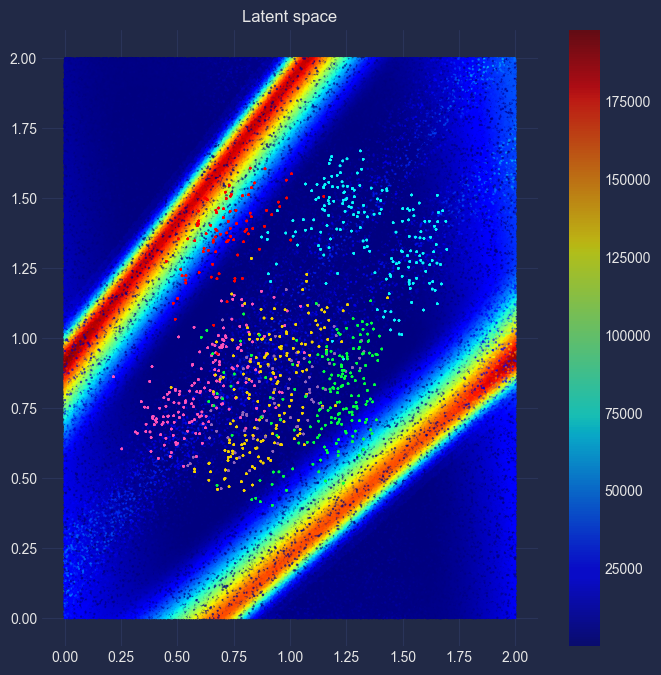

 30%|███       | 30013/100001 [05:49<8:16:56,  2.35it/s] 

30000:(beta)=(    0.6568)


 31%|███       | 31022/100001 [05:57<09:02, 127.16it/s] 

31000:(beta)=(    0.6255)


 32%|███▏      | 32019/100001 [06:06<09:57, 113.74it/s]

32000:(beta)=(    0.8442)


 33%|███▎      | 33018/100001 [06:15<09:35, 116.48it/s]

33000:(beta)=(    0.9996)


 34%|███▍      | 34016/100001 [06:24<09:23, 117.02it/s]

34000:(beta)=(    0.8690)


 35%|███▌      | 35021/100001 [06:33<09:29, 114.01it/s]

35000:(beta)=(    0.6396)


 36%|███▌      | 36012/100001 [06:42<09:22, 113.85it/s]

36000:(beta)=(    0.6400)


 37%|███▋      | 37011/100001 [06:50<08:39, 121.17it/s]

37000:(beta)=(    0.8697)


 38%|███▊      | 38014/100001 [06:59<08:57, 115.23it/s]

38000:(beta)=(    0.9995)


 39%|███▉      | 39014/100001 [07:07<07:45, 131.15it/s]

39000:(beta)=(    0.8435)


 40%|███▉      | 39998/100001 [07:30<09:46, 102.39it/s]

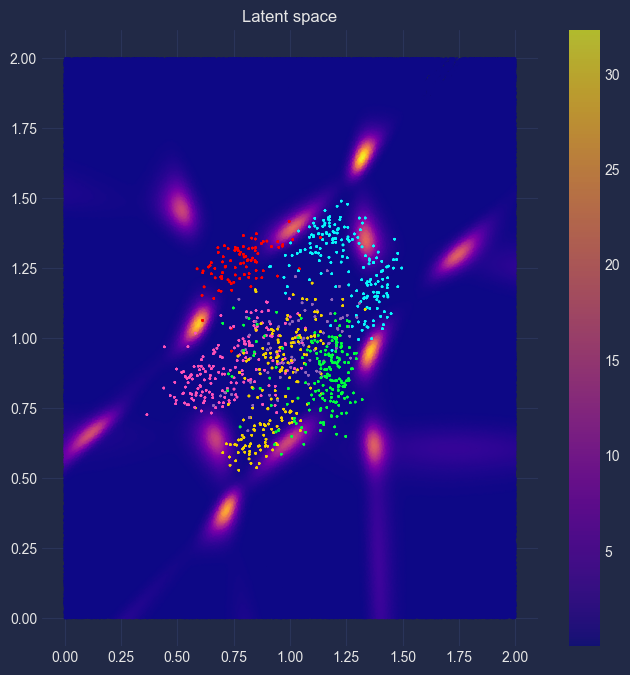

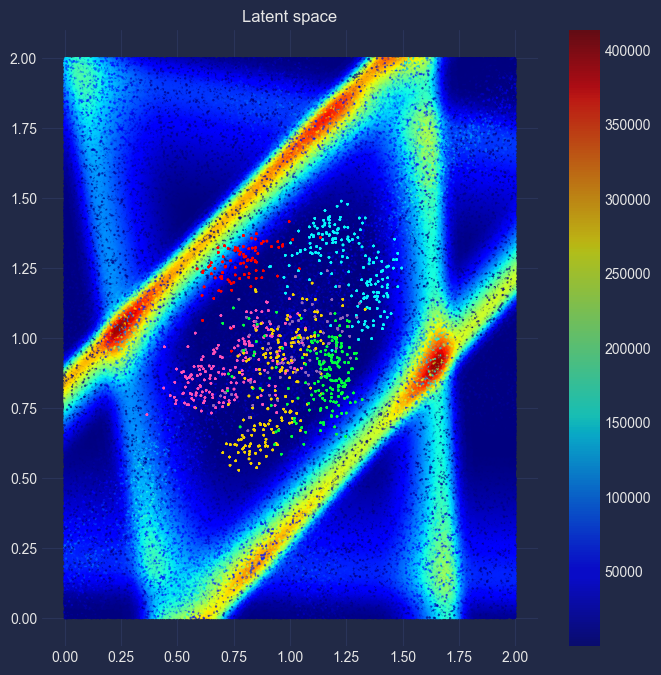

 40%|████      | 40012/100001 [07:37<7:35:27,  2.20it/s] 

40000:(beta)=(    0.6251)


 41%|████      | 41016/100001 [07:46<08:03, 122.06it/s] 

41000:(beta)=(    0.6573)


 42%|████▏     | 42013/100001 [07:54<08:46, 110.18it/s]

42000:(beta)=(    0.8939)


 43%|████▎     | 43021/100001 [08:03<08:14, 115.18it/s]

43000:(beta)=(    0.9960)


 44%|████▍     | 44022/100001 [08:12<08:04, 115.59it/s]

44000:(beta)=(    0.8172)


 45%|████▌     | 45021/100001 [08:20<07:30, 121.91it/s]

45000:(beta)=(    0.6138)


 46%|████▌     | 46022/100001 [08:28<07:27, 120.74it/s]

46000:(beta)=(    0.6771)


 47%|████▋     | 47018/100001 [08:36<07:20, 120.32it/s]

47000:(beta)=(    0.9165)


 48%|████▊     | 48021/100001 [08:45<07:08, 121.42it/s]

48000:(beta)=(    0.9889)


 49%|████▉     | 49020/100001 [08:53<06:53, 123.41it/s]

49000:(beta)=(    0.7907)


 50%|████▉     | 49997/100001 [09:20<07:01, 118.74it/s]

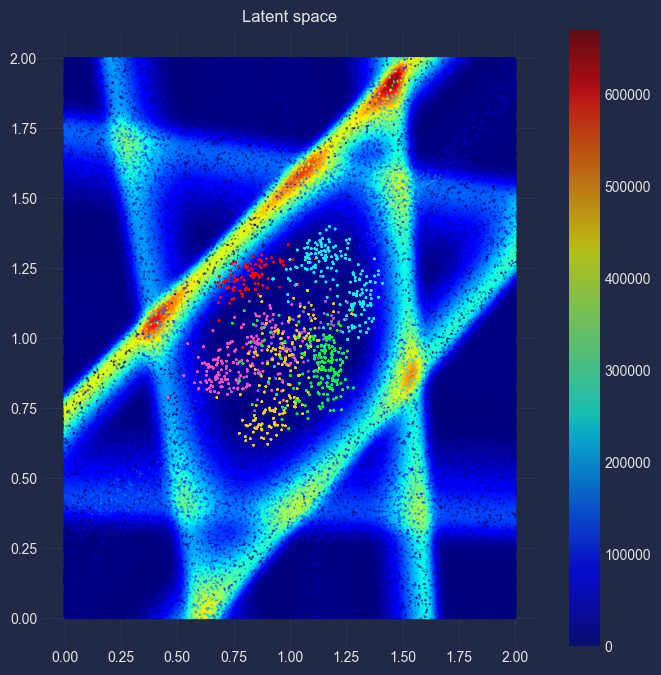

 50%|█████     | 50012/100001 [09:22<5:59:32,  2.32it/s]

50000:(beta)=(    0.6058)


 51%|█████     | 51022/100001 [09:30<06:42, 121.56it/s] 

51000:(beta)=(    0.6992)


 52%|█████▏    | 52016/100001 [09:39<06:25, 124.39it/s]

52000:(beta)=(    0.9370)


 53%|█████▎    | 53024/100001 [09:48<06:24, 122.03it/s]

53000:(beta)=(    0.9786)


 54%|█████▍    | 54017/100001 [09:56<06:22, 120.34it/s]

54000:(beta)=(    0.7643)


 55%|█████▌    | 55026/100001 [10:05<06:01, 124.25it/s]

55000:(beta)=(    0.6012)


 56%|█████▌    | 56017/100001 [10:15<05:59, 122.41it/s]

56000:(beta)=(    0.7230)


 57%|█████▋    | 57023/100001 [10:24<05:36, 127.65it/s]

57000:(beta)=(    0.9551)


 58%|█████▊    | 58023/100001 [10:32<05:40, 123.20it/s]

58000:(beta)=(    0.9650)


 59%|█████▉    | 59023/100001 [10:41<05:34, 122.44it/s]

59000:(beta)=(    0.7385)


 60%|█████▉    | 60000/100001 [11:00<05:33, 119.97it/s]

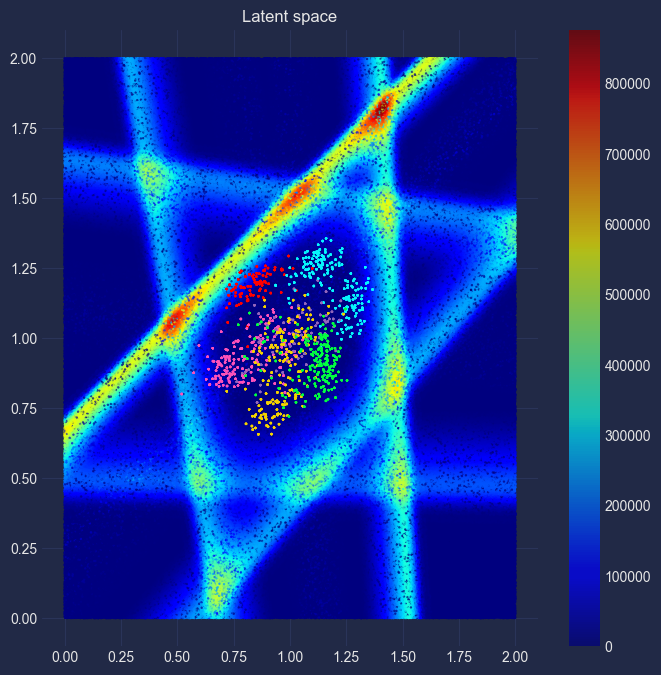

 60%|██████    | 60012/100001 [11:09<5:00:19,  2.22it/s]

60000:(beta)=(    0.6001)


 61%|██████    | 61016/100001 [11:18<05:58, 108.84it/s] 

61000:(beta)=(    0.7481)


 62%|██████▏   | 62012/100001 [11:27<05:41, 111.15it/s]

62000:(beta)=(    0.9705)


 63%|██████▎   | 63018/100001 [11:36<05:25, 113.76it/s]

63000:(beta)=(    0.9486)


 64%|██████▍   | 64013/100001 [11:44<04:52, 123.16it/s]

64000:(beta)=(    0.7138)


 65%|██████▌   | 65017/100001 [11:52<04:35, 127.13it/s]

65000:(beta)=(    0.6025)


 66%|██████▌   | 66020/100001 [11:59<04:19, 130.70it/s]

66000:(beta)=(    0.7742)


 67%|██████▋   | 67013/100001 [12:08<05:08, 106.99it/s]

67000:(beta)=(    0.9829)


 68%|██████▊   | 68019/100001 [12:18<05:13, 102.14it/s]

68000:(beta)=(    0.9295)


 69%|██████▉   | 69018/100001 [12:27<04:41, 110.14it/s]

69000:(beta)=(    0.6906)


 70%|██████▉   | 70000/100001 [12:50<04:34, 109.23it/s]

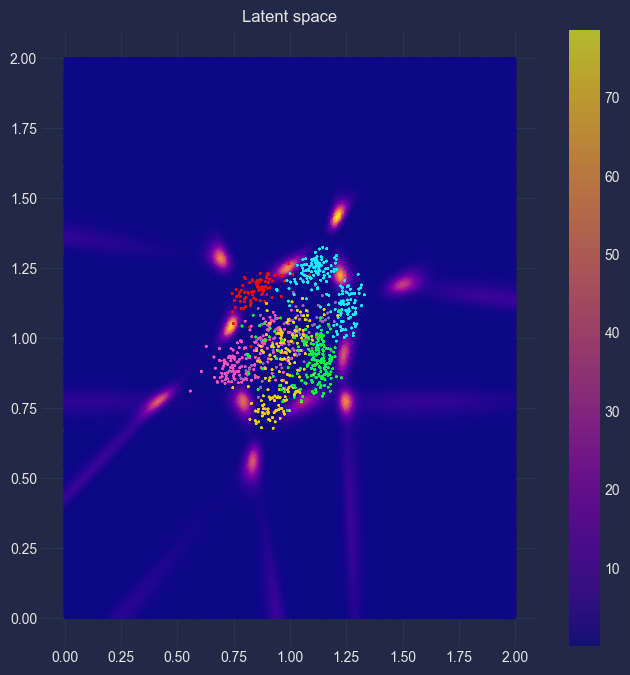

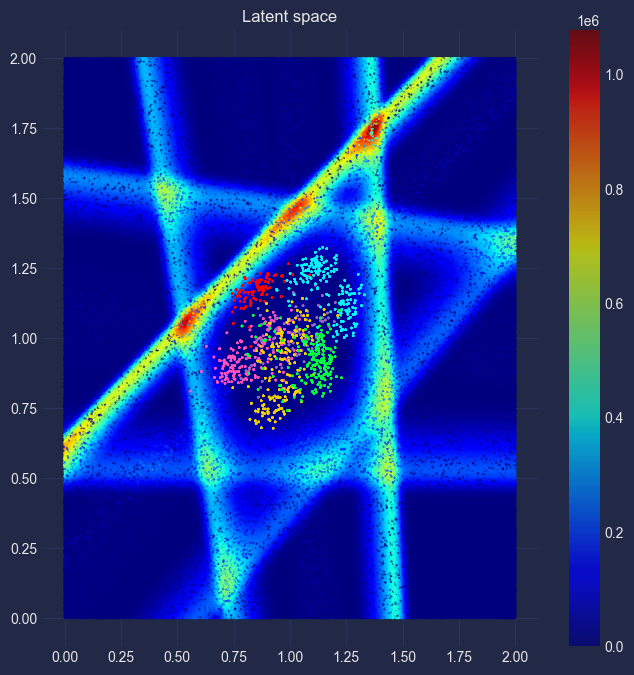

 70%|███████   | 70009/100001 [12:58<4:44:32,  1.76it/s]

70000:(beta)=(    0.6084)


 71%|███████   | 71021/100001 [13:07<04:04, 118.76it/s] 

71000:(beta)=(    0.8007)


 72%|███████▏  | 72015/100001 [13:15<03:42, 126.01it/s]

72000:(beta)=(    0.9920)


 73%|███████▎  | 73016/100001 [13:23<03:26, 130.71it/s]

73000:(beta)=(    0.9082)


 74%|███████▍  | 74025/100001 [13:31<03:26, 125.81it/s]

74000:(beta)=(    0.6694)


 75%|███████▌  | 75021/100001 [13:38<03:08, 132.52it/s]

75000:(beta)=(    0.6177)


 76%|███████▌  | 76026/100001 [13:46<03:08, 127.46it/s]

76000:(beta)=(    0.8272)


 77%|███████▋  | 77017/100001 [13:54<03:11, 119.83it/s]

77000:(beta)=(    0.9977)


 78%|███████▊  | 78024/100001 [14:03<03:03, 119.60it/s]

78000:(beta)=(    0.8849)


 79%|███████▉  | 79016/100001 [14:11<03:01, 115.61it/s]

79000:(beta)=(    0.6505)


 80%|███████▉  | 79989/100001 [14:30<02:46, 120.23it/s]

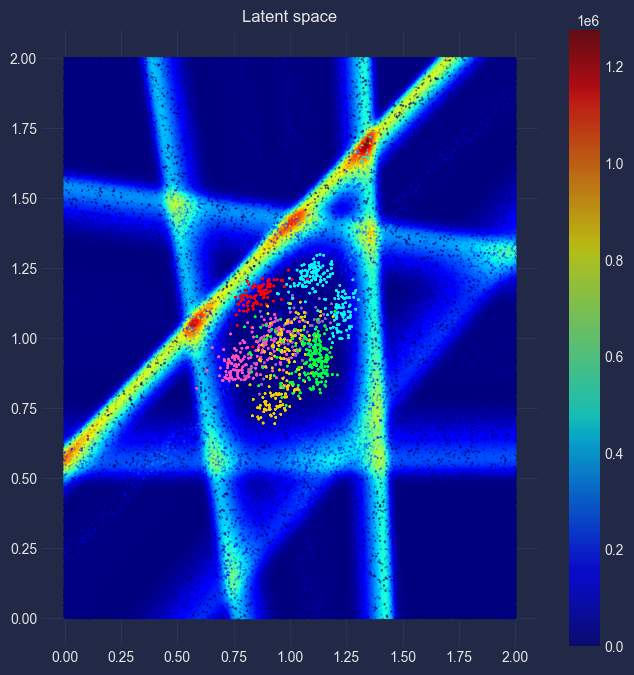

 80%|████████  | 80011/100001 [14:41<2:10:40,  2.55it/s]

80000:(beta)=(    0.6302)


 81%|████████  | 81021/100001 [14:50<02:34, 122.59it/s] 

81000:(beta)=(    0.8533)


 82%|████████▏ | 82013/100001 [14:58<02:43, 110.07it/s]

82000:(beta)=(    1.0000)


 83%|████████▎ | 83016/100001 [15:07<02:20, 120.79it/s]

83000:(beta)=(    0.8602)


 84%|████████▍ | 84021/100001 [15:16<02:13, 120.02it/s]

84000:(beta)=(    0.6342)


 85%|████████▌ | 85019/100001 [15:25<02:04, 120.82it/s]

85000:(beta)=(    0.6458)


 86%|████████▌ | 86017/100001 [15:33<01:58, 117.64it/s]

86000:(beta)=(    0.8783)


 87%|████████▋ | 87022/100001 [15:42<01:49, 118.79it/s]

87000:(beta)=(    0.9987)


 88%|████████▊ | 88025/100001 [15:49<01:34, 127.09it/s]

88000:(beta)=(    0.8344)


 89%|████████▉ | 89020/100001 [15:57<01:29, 122.07it/s]

89000:(beta)=(    0.6208)


 90%|████████▉ | 89993/100001 [16:20<01:20, 124.20it/s]

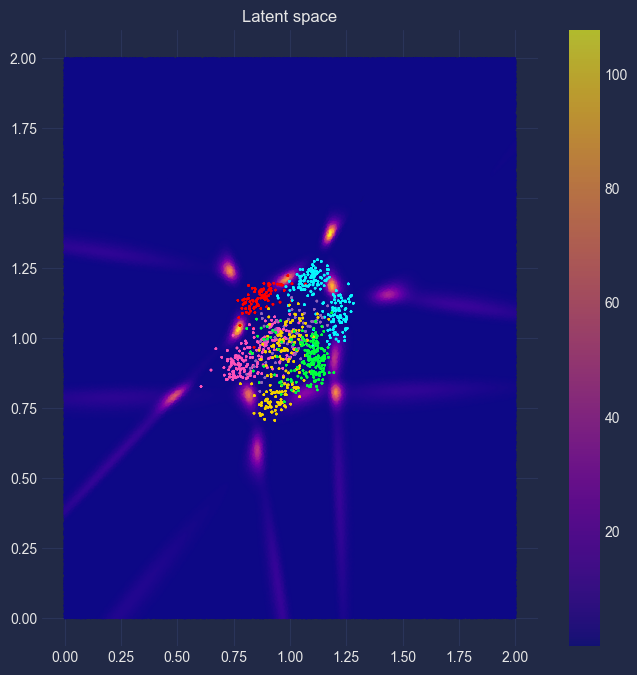

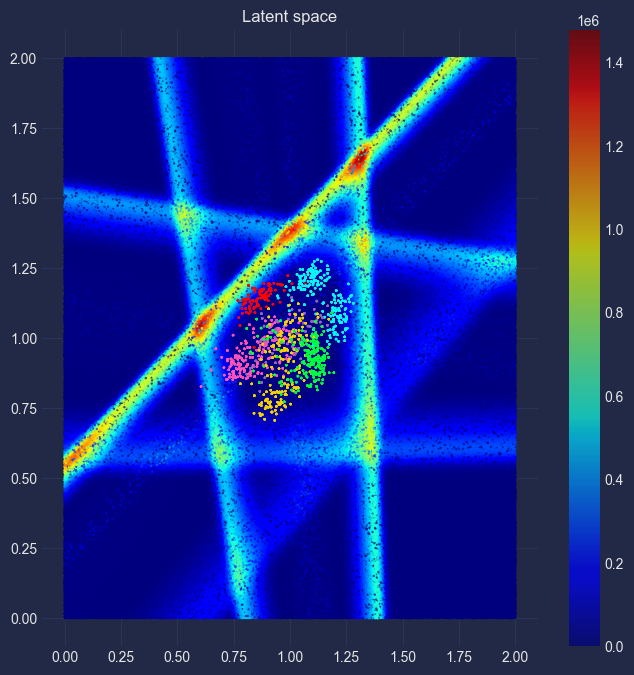

 90%|█████████ | 90014/100001 [16:25<59:07,  2.82it/s]  

90000:(beta)=(    0.6640)


 91%|█████████ | 91013/100001 [16:33<01:14, 121.42it/s]

91000:(beta)=(    0.9021)


 92%|█████████▏| 92017/100001 [16:42<01:08, 117.15it/s]

92000:(beta)=(    0.9939)


 93%|█████████▎| 93018/100001 [16:50<00:56, 122.71it/s]

93000:(beta)=(    0.8079)


 94%|█████████▍| 94015/100001 [16:58<00:48, 122.85it/s]

94000:(beta)=(    0.6106)


 95%|█████████▌| 95017/100001 [17:07<00:42, 117.79it/s]

95000:(beta)=(    0.6846)


 96%|█████████▌| 96024/100001 [17:15<00:32, 123.97it/s]

96000:(beta)=(    0.9240)


 97%|█████████▋| 97016/100001 [17:23<00:25, 117.86it/s]

97000:(beta)=(    0.9857)


 98%|█████████▊| 98023/100001 [17:30<00:08, 221.53it/s]

98000:(beta)=(    0.7814)


 99%|█████████▉| 99023/100001 [17:38<00:07, 126.39it/s]

99000:(beta)=(    0.6038)


100%|█████████▉| 99987/100001 [17:58<00:00, 138.68it/s]

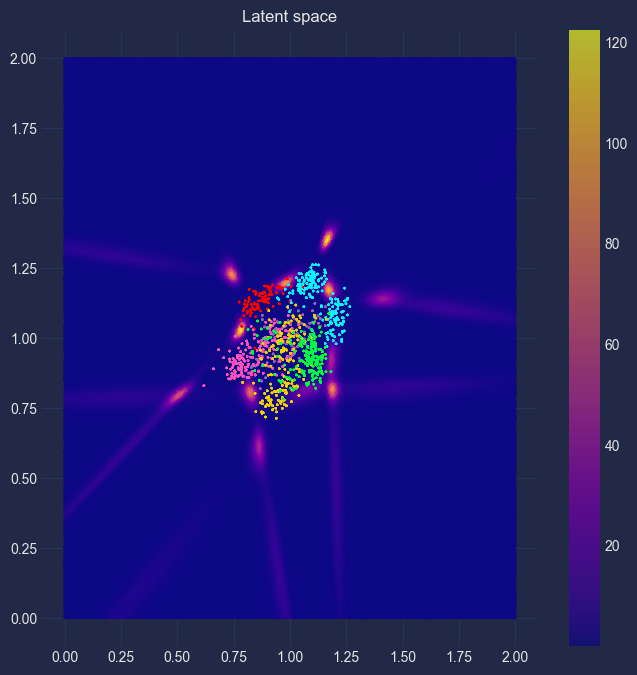

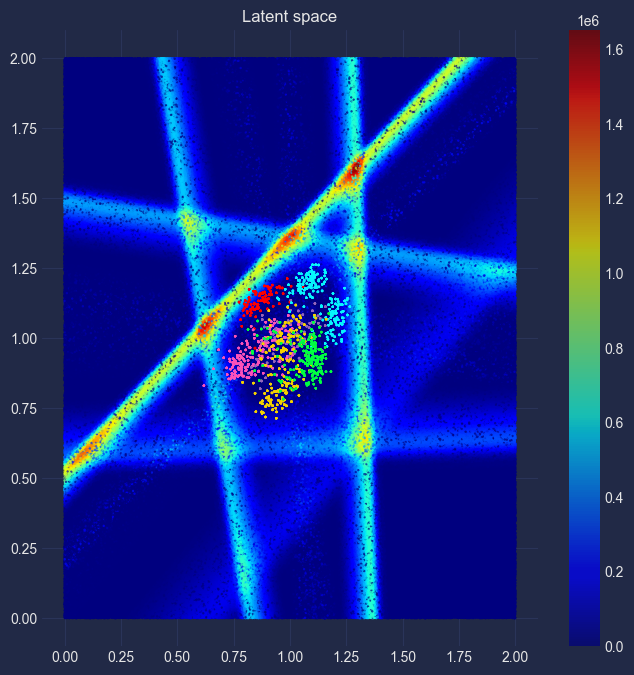

100%|██████████| 100001/100001 [18:05<00:00, 92.12it/s]

100000:(beta)=(    0.7073)


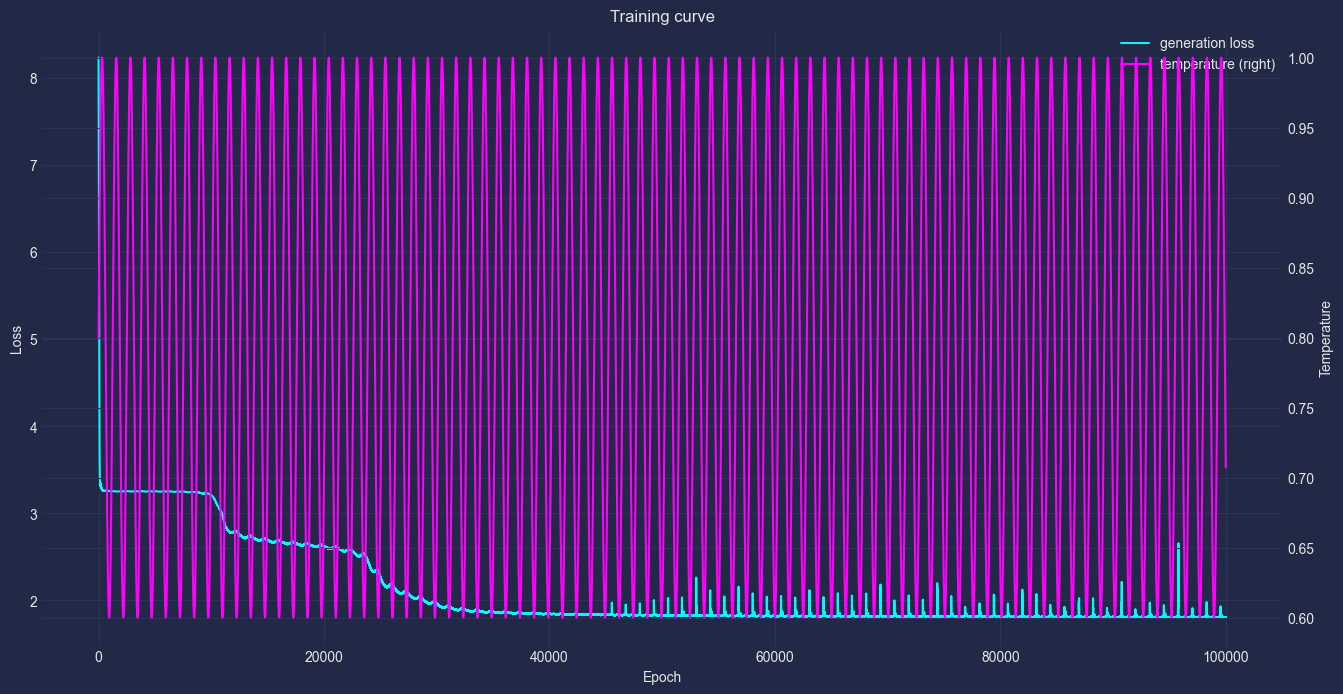

In [4]:
# Optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
#optimizer = optim.Adam(params, lr=5e-5, betas=(0.5, 0.999))
optimizer = optim.SGD(params, lr=1e-3, momentum=0.1)

# Training loop
ac_list = []
gen_loss_list = []
val_list = []
val_gen_loss_list = []
beta_list = []
fifs_list = []

beta_min = 1/5   # must be less than 1/2
cyclical_beta = (1 - beta_min) + beta_min * np.sin(500/n_epoch * np.arange(n_epoch))

for j in tqdm(range(n_epoch)):
    optimizer.zero_grad()
    
    loc, scale = encoder(x)
    prior = Normal(torch.zeros_like(loc), torch.ones_like(scale))
    posterior = Normal(loc, scale)
    z_sample = torch.add(loc, scale.pow_(prior.sample()))
    z_sample.requires_grad_(True)
    
    dec = decoder(z_sample)
    dec.requires_grad_(True)
    log_probs = Bernoulli(probs=dec.pow_(cyclical_beta[j])).log_prob(y)
 
    if j % 10000 == 0:
        n_vis = 10
        enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
        enc_test_label = np.tile(yl_train, (n_vis))
        n_vis = 1000
        z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
        decoder_params = dict(decoder.named_parameters())
        mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
        fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=mfs, cmap=plt.cm.Reds,
                    c=mfs, cmap=plt.cm.plasma,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()
        
        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=fifs, cmap=plt.cm.Greens,
                    c=fifs, cmap=plt.cm.jet,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()


    # Loss functions
    kl_divergence = torch.distributions.kl_divergence(posterior, prior).mean()
    recon_likelihood = log_probs.sum(dim=1).mean()
    gen_loss = torch.sub(kl_divergence, recon_likelihood)
    
    gen_loss.backward(retain_graph=True)
    optimizer.step()

    with torch.no_grad():
        correct = (y.argmax(dim=1) == dec.argmax(dim=1)).float()
        accuracy = correct.mean()
        ac_list.append(accuracy.item())
        gen_loss_list.append(gen_loss.item())
        beta_list.append(cyclical_beta[j])
        
        if j % 1000 == 0:
            print("%5d:(beta)=(%10.4f)" % (j, cyclical_beta[j]))

rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()
ax1.plot(np.arange(n_epoch), np.asarray(gen_loss_list), label='generation loss')
#ax1.plot(np.arange(n_epoch), np.asarray(val_gen_loss_list), label='validation generation loss')
ax2.plot(np.arange(n_epoch), np.asarray(beta_list), label='temperature (right)', color='magenta')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.1)
plt.title('Training curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Temperature')
plt.show()

In [5]:
loc, scale = encoder(x)
z_sample = torch.add(loc, scale.pow_(prior.sample()))
z_sample.requires_grad_(True)
dec = decoder(z_sample)
dec.requires_grad_(True)
jacobian = compute_jacobian(decoder, decoder_params, z_sample)

n_vis = 10
enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
enc_test_label = np.tile(yl_train, (n_vis))
n_vis = 1000
z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
decoder_params = dict(decoder.named_parameters())
mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

print(mfs.shape)
print(z_range[:, 0].shape)
print(z_range[:, 1].shape)
print(enc_test.shape)
print(enc_test_label.shape)

(898000,)
(898000,)
(898000,)
(8980, 2)
(8980,)


In [6]:
print(enc_test)
print(enc_test_label)

[[1.0427737  1.1673123 ]
 [0.98011416 0.81380206]
 [0.8190864  0.9664743 ]
 ...
 [1.1309881  1.0087833 ]
 [0.8860719  1.1823478 ]
 [0.86811817 0.81676483]]
[6 2 1 ... 9 4 5]


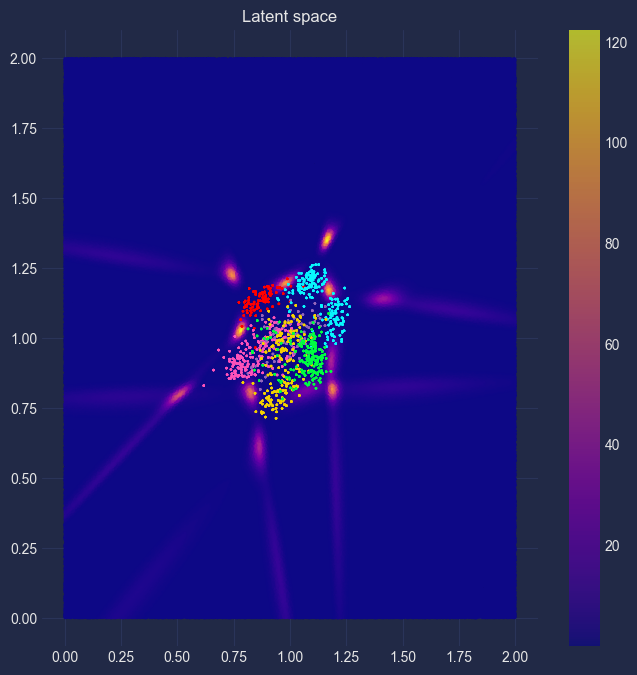

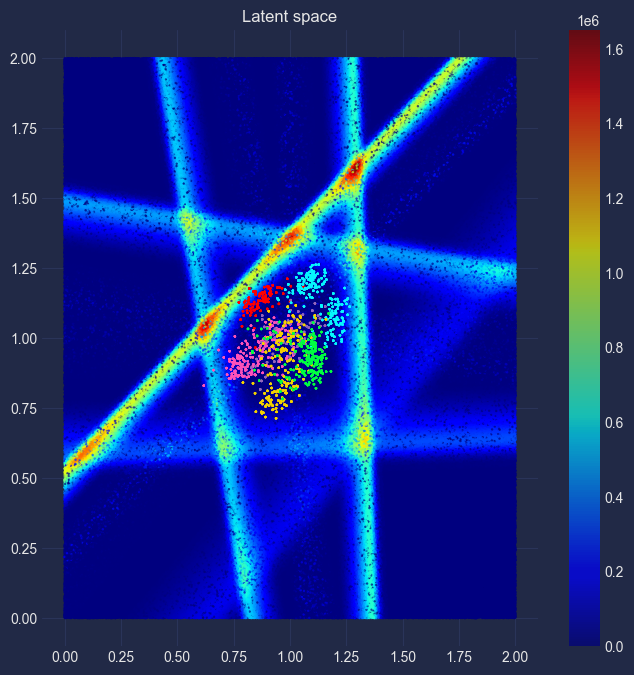

In [7]:
rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=mfs, cmap=plt.cm.plasma,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()

rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=fifs, cmap=plt.cm.jet,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()